<div class="alert alert-info"><b>Описание проекта:</b>
   
# "Определение возраста покупателей"

***

**Цели проекта:**
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
- контролировать добросовестность кассиров при продаже алкоголя
    
***
    
**Задачи исследования:**  
- построить модель, которая по фотографии определит приблизительный возраст человека
    
***
    
**Этапы исследования:** 
- исследовательский анализ набора фотографий
- подготовка данных к обучению
- обучение нейронной сети и расчет её качества
    
***

    
</div>

***

## Исследовательский анализ данных

In [1]:
import warnings

import pandas as pd
import numpy as np

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, Dropout, GlobalAveragePooling2D

import matplotlib.pyplot as plt

# Избавляемся от вывода предупреждений
warnings.simplefilter("ignore")

# Отображение всех колонок
pd.set_option('display.max_columns', None)

In [2]:
# Загрузка данных.
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
# Выведем первые 5 строк датасета.
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
# Узнаем размер выборки
labels.shape

(7591, 2)

In [5]:
# Посмотрим распределение численных значений признаков.
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


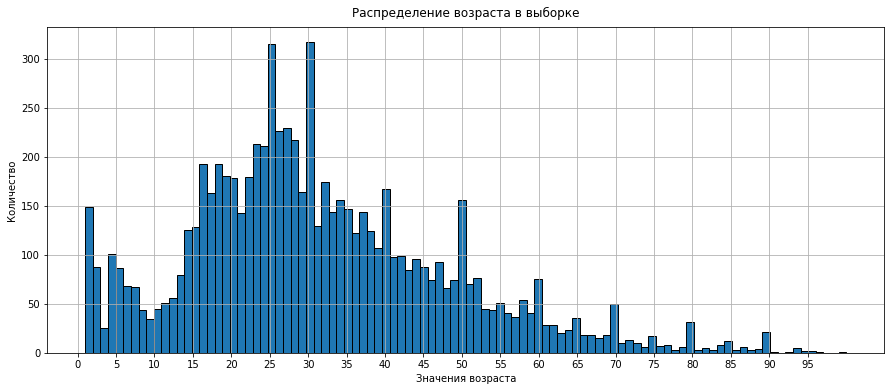

In [13]:
# Построим график распределения возраста в выборке.
labels.real_age.hist(bins=100, edgecolor = 'black', figsize = (15, 6));
plt.xlabel('Значения возраста')
plt.ylabel('Количество')
plt.xticks(range(0, labels['real_age'].max(), 5))
plt.title("Распределение возраста в выборке", pad = 10);

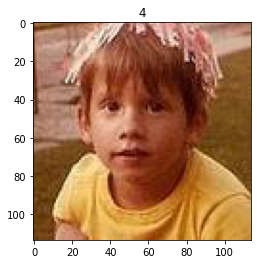

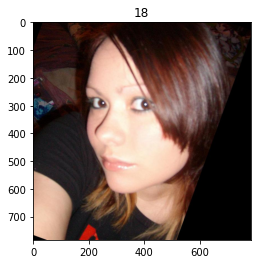

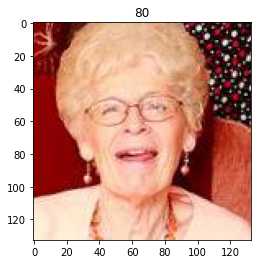

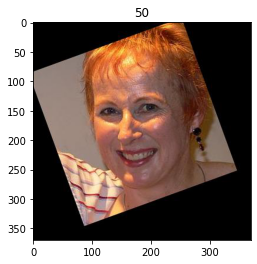

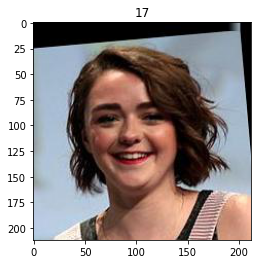

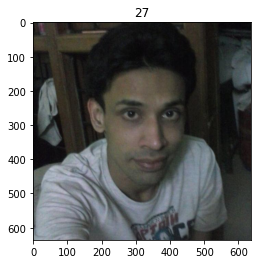

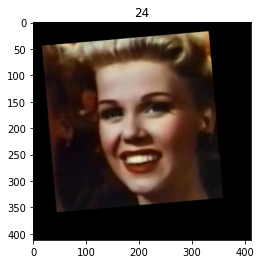

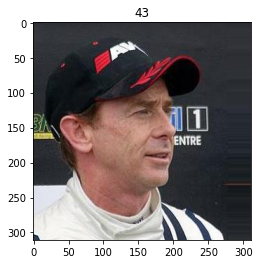

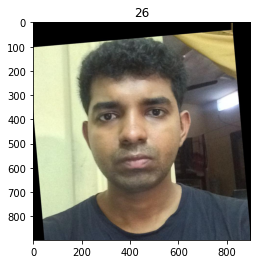

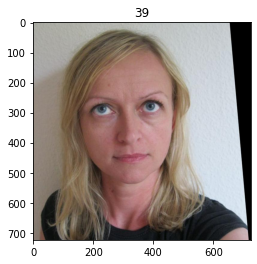

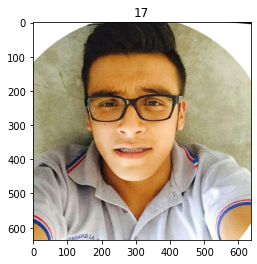

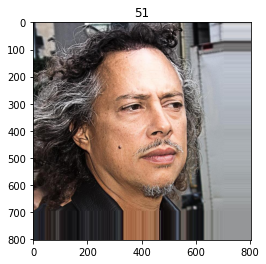

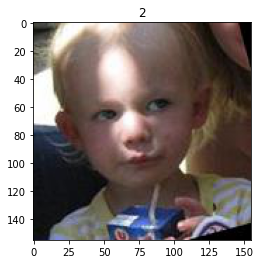

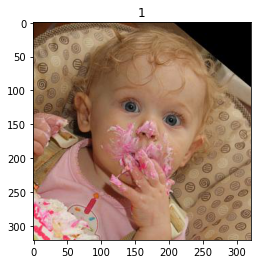

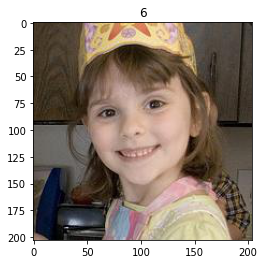

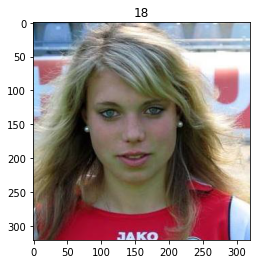

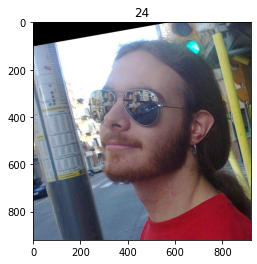

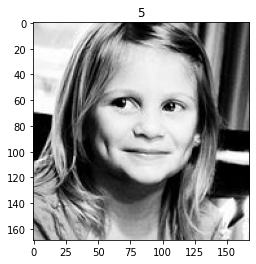

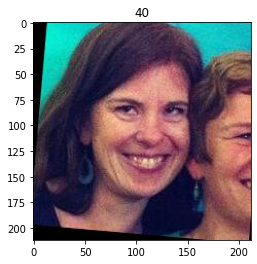

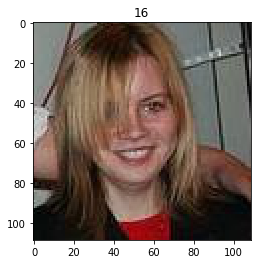

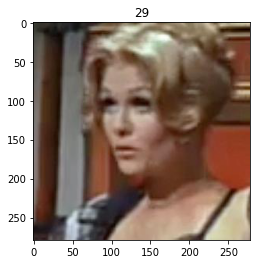

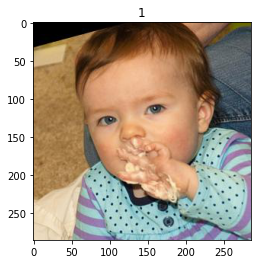

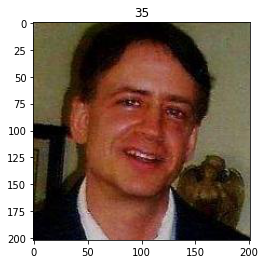

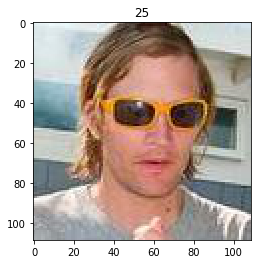

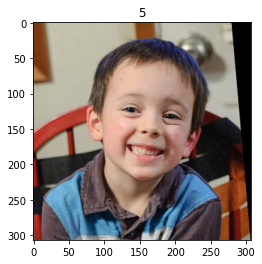

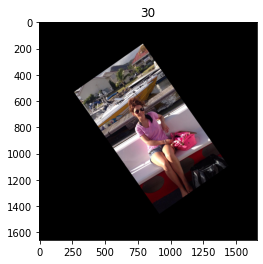

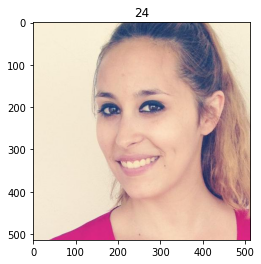

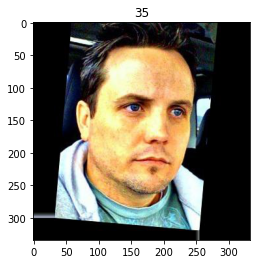

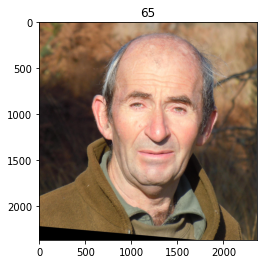

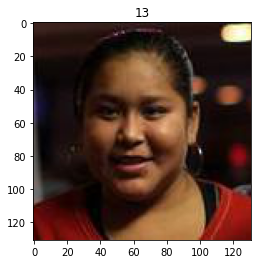

In [15]:
# Выведем на экран до 30 изображений.

num = 30
for i in range(num):
    if i < 10:
        image = Image.open(f'/datasets/faces/final_files/00000{i}.jpg')
        array = np.array(image)        
    else:
        image = Image.open(f'/datasets/faces/final_files/0000{i}.jpg')
        array = np.array(image)        
    plt.figure()
    plt.imshow(array)
    plt.title(labels.real_age[i])

<div class="alert alert-info"><b>Комментарий:</b>
   
Размер датасета составляет 7591 запись о возрасте человека (от 1 до 100 лет) и соответствующего ему изображения.   
В целом фотографии ориентированы правильно (вертикально), однако имеются примеры фотографий, которые повернуты как по, так и против часовой стрелки (до 45 градусов), что необходимо учитывать при аугментации обучающих данных.    
Размеры исходных изображений разные, что потребует их приведения к одному размеру при обучении моделей. Также в выборке представлены черно-белые фотографии.   
При этом представлено относительно небольшое количество изображений людей в возасте от 70 лет и старше, на основании чего можно предположить, что модель будет ошибаться чаще в данном возрастном диапазоне.    
    
</div>

***

## Обучение модели

```
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, Dropout, GlobalAveragePooling2D

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rotation_range=40,           
        width_shift_range=0.2,       
        height_shift_range=0.2,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    valid_datagen = ImageDataGenerator(
        validation_split=0.25,        
        rescale=1./255)
    valid_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return valid_gen_flow

 
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,                        
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
     
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None): 
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2) 

    return model

```

# Результат:

```
Train for 356 steps, validate for 119 steps
Epoch 1/15
356/356 - 103s - loss: 239.1383 - mae: 11.3669 - val_loss: 812.2137 - val_mae: 23.5570
Epoch 2/15
356/356 - 100s - loss: 120.2751 - mae: 8.3539 - val_loss: 201.9983 - val_mae: 10.3934
Epoch 3/15
356/356 - 104s - loss: 105.7396 - mae: 7.7939 - val_loss: 93.6396 - val_mae: 7.0060
Epoch 4/15
356/356 - 103s - loss: 89.7769 - mae: 7.1871 - val_loss: 89.9360 - val_mae: 7.0423
Epoch 5/15
356/356 - 104s - loss: 78.0239 - mae: 6.7581 - val_loss: 125.5407 - val_mae: 8.4204
Epoch 6/15
356/356 - 104s - loss: 74.2753 - mae: 6.5841 - val_loss: 108.9256 - val_mae: 8.2567
Epoch 7/15
356/356 - 103s - loss: 64.5645 - mae: 6.1515 - val_loss: 88.7146 - val_mae: 6.9815
Epoch 8/15
356/356 - 103s - loss: 59.1776 - mae: 5.8848 - val_loss: 104.7297 - val_mae: 7.5969
Epoch 9/15
356/356 - 104s - loss: 53.9457 - mae: 5.6920 - val_loss: 86.6250 - val_mae: 6.9672
Epoch 10/15
356/356 - 104s - loss: 55.1857 - mae: 5.6493 - val_loss: 112.2186 - val_mae: 8.0213
Epoch 11/15
356/356 - 103s - loss: 45.5173 - mae: 5.2202 - val_loss: 84.0369 - val_mae: 6.8646
Epoch 12/15
356/356 - 93s - loss: 43.5397 - mae: 5.0579 - val_loss: 87.3891 - val_mae: 6.6927
Epoch 13/15
356/356 - 90s - loss: 39.4802 - mae: 4.8154 - val_loss: 79.8875 - val_mae: 6.5626
Epoch 14/15
356/356 - 90s - loss: 35.9317 - mae: 4.5974 - val_loss: 80.6796 - val_mae: 6.5515
Epoch 15/15
356/356 - 90s - loss: 34.5361 - mae: 4.5427 - val_loss: 72.8185 - val_mae: 6.2393
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 72.8185 - mae: 6.2393
Test MAE: 6.2393
```

***

<div class="alert alert-info"><b>Анализ обученной модели:</b>
   
Для обучения я использовал модель ResNet50 без добавления 'верхушки', в которой при обучении были инициализированы веса ImageNet.   
К тренировочным данным были добавлены аугментации: отражение по горизонтали, повороты до 40 градусов, свиги изображения по вертикали и горизонтали на 20% от исходного размера. Размер тестовой выборки составил 25 % от общего размера.    

По итогам обучения модель показала значение MAE на тестовых данных - 6.2393.
</div>